## Stable Moving CA

### Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from tqdm import tqdm

import IPython
from IPython.display import display, HTML

In [75]:
#device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


### Model

In [86]:
class CA(nn.Module):
    def __init__(self):
        super(CA, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 1, padding=0)
        self.conv3 = nn.Conv2d(8, 2, 1, padding=0)
        #self.conv2 = nn.Linear(8, 8)
        #self.conv3 = nn.Linear(8, 2, bias=False)
        with torch.no_grad():
            self.conv3.weight.zero_() #todo should this be done for this, none or all of them?
        self.alive = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    def alive_filter(self, x):
        #return nn.MaxPool2d()
        #return self.alive(x[:, 3:4, :, :]) > 0.1 #need to have any cell within kernel size be alive 
        return self.alive(x) > 0.1 #need to have any cell within kernel size be alive 

    def perceive(self, x):
        return torch.relu(self.conv1(x))
        #return (self.conv1(x))

    def update(self, x):
        pre_life_mask = self.alive_filter(x)
        z = self.perceive(x)
        z = torch.relu(self.conv2(z))
        z = self.conv3(z)
        post_life_mask = self.alive_filter(z)
        life_mask = torch.bitwise_and(pre_life_mask, post_life_mask).to(torch.float)
        z = z * life_mask #mask
        #z = torch.sigmoid(z)
        return z

    def forward(self, x, steps):
        for _ in range(steps):
            x = self.update(x)
            #trying to ensure 
            #scale = torch.sum(x) / torch.sum(z)
            #z = torch.mul(z, scale)

            #trying to ensure the same amount of alive CAs
            #alive_count = torch.count_nonzero(torch.where(z > 0.1, z, 0))
            #return z, alive_count
        return x

        #add helper functions

### Training

In [95]:
def get_random_state():
    mat = torch.zeros(32, 32, device=device)
    #mat = torch.zeros(32, 32, 8, device=device)
    mat2 = torch.rand(5,5, device=device) > 0.7

    #mat[14:19,14:19, 0] = mat2
    mat[14:19,14:19] = mat2
    zeros = torch.zeros_like(mat, device=device)
    #state = torch.stack([1 - mat, mat])
    state = torch.stack([mat, zeros])
    return state

def train(model, iterations, optimizer, criterion, epochs=1):
    losses = np.zeros(iterations * epochs // 10)
    for epoch in tqdm(range(epochs)):
        for i in range(iterations):
            if iterations % 1000 == 0:
                state = get_random_state()
            #input_alive_count = torch.count_nonzero(torch.where(state > 0.1, state, 0)).type(torch.float32)
            #could use this to mask out all except the top n cells

            #torch.where(x > 0 | x<0.1, x, y)
            #kunne lave en tensor med count på mellem 0.0-0.1, 0.1-0.2, 0.2-0.3 ...

            optimizer.zero_grad()
            #state.requires_grad = True
            state_hat = model(state, epoch+1)

            #scale = torch.sum(state) / torch.sum(state_hat)
            loss = criterion(state_hat, state)

            #loss2 = criterion(scale, torch.tensor([1.0], device=device))
            #alive_count = alive_count.type(torch.float32)
            #loss3 = criterion(alive_count, input_alive_count) * 0.000001
            #loss = loss1 #+ loss2 #+ loss3

            if i % 10 == 0: 
                losses[epoch*iterations//10 + i//10] = loss.item()
            loss.backward()
            optimizer.step()
        print(loss)
    return model, losses

### Main

In [96]:
#initial state
#...
model = CA().to(device)
iterations = 50000
epochs = 1
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model, losses = train(model, iterations, optimizer, criterion, epochs)

100%|██████████| 1/1 [01:22<00:00, 82.61s/it]

tensor(5.7907e-11, device='cuda:0', grad_fn=<MseLossBackward0>)


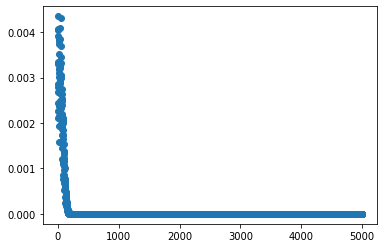

In [97]:
fig, ax = plt.subplots()

losses1 = [[i, value] for i, value in enumerate(losses)]
losses1 = np.array(losses1)

losses2 = losses1[:,1]
#ax.plot(losses)
ax.scatter(losses1[:, 0], losses2)
#ax.set_yscale('logit')
#ax.set_ylim([0.0000000001,0.001])

plt.show()

[2.33864179e-03 3.49046220e-03 3.06784385e-03 ... 2.85647117e-10
 1.37601164e-09 4.75932849e-10]
0.48446460562021215


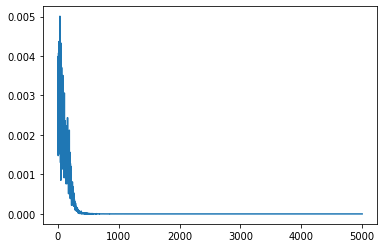

In [36]:
print(losses)
plt.plot(losses)
print(np.sum(losses))

In [23]:
#save progress
torch.save(model.state_dict(), 'models/model_ca_6.pth')

### Test - Animate

In [24]:
#model = CA()
#model.load_state_dict(torch.load('models/model_ca_3.pth'))
#model = model.to(device)

In [66]:
#Setup
state = get_random_state()
state = state.float().unsqueeze(0).to(device)
print(state.shape)

torch.Size([1, 2, 32, 32])


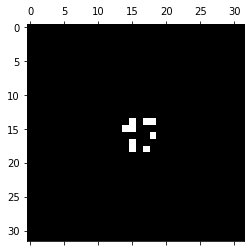

In [98]:
#iterate
@torch.no_grad()
def animate(i):
    global state
    #state = torch.softmax(model(state), dim=1).to(device) #calculate new state
    state = model(state, 1) #calculate new state
    mat.set_data(state.detach().cpu().numpy()[0,0]) #update the mat shown to reflect the new state

fig, ax = plt.subplots()
mat = ax.matshow(state.detach().cpu().numpy()[0,0], cmap="gray") #show mat in fig

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

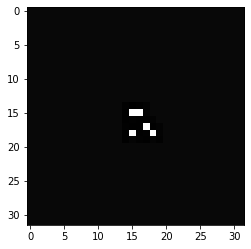

In [27]:
state1 = state
state1 = model(state1, 1)
plt.imshow(state1.reshape(2, 32,32).cpu().detach().numpy()[0], cmap='gray')

In [28]:
print(model)

CA(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (alive): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
)


In [29]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[-0.0026,  0.2328, -0.0069],
          [ 0.2188,  0.6871,  0.0978],
          [ 0.0530,  0.0722,  0.2076]],

         [[ 0.2195,  0.1863, -0.1623],
          [ 0.1279, -0.0483, -0.0928],
          [ 0.1773,  0.0369,  0.1197]]],


        [[[ 0.0700,  0.1568,  0.0643],
          [ 0.0619, -0.1508,  0.1239],
          [ 0.0313,  0.1613,  0.2746]],

         [[-0.2156,  0.0443,  0.1148],
          [ 0.2166,  0.1494, -0.2156],
          [ 0.1964,  0.1265, -0.1172]]],


        [[[ 0.0120,  0.1931, -0.0818],
          [ 0.0597, -0.2306,  0.1422],
          [ 0.1282,  0.0144,  0.0100]],

         [[-0.1583,  0.1566, -0.1142],
          [-0.1376, -0.0672,  0.0788],
          [ 0.1101, -0.1461,  0.1005]]],


        [[[ 0.1847,  0.1254,  0.2471],
          [ 0.3576, -0.0901,  0.1760],
          [ 0.2535,  0.2501,  0.2870]],

         [[-0.0938, -0.0556,  0.0821],
          [-0.0216,  0.2091,  0.1880],
          [ 0.1060, -0.1626, -0.1550]]],


        [[[ 0.0245

In [30]:
print(torch.sum(state1))

tensor(4.3141, device='cuda:0', grad_fn=<SumBackward0>)
